#                                                       The Black-Scholes PDE

### Imports:

In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

from IPython.display import display
import sympy 
sympy.init_printing()

### Data Analysis:
- Used Tesla Stock Price dataset recorded from 2010 to 2017
- Dataset link: https://www.kaggle.com/datasets/rpaguirre/tesla-stock-price 

In [2]:
df = pd.read_csv("Tesla.csv - Tesla.csv.csv", index_col=0, parse_dates=True)
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [3]:
df.tail()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2017-03-13,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
2017-03-14,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
2017-03-15,257.000000,261.000000,254.270004,255.729996,4816600,255.729996
2017-03-16,262.399994,265.750000,259.059998,262.049988,7100400,262.049988
2017-03-17,264.000000,265.329987,261.200012,261.500000,6475900,261.500000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2010-06-29 to 2017-03-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1692 non-null   float64
 1   High       1692 non-null   float64
 2   Low        1692 non-null   float64
 3   Close      1692 non-null   float64
 4   Volume     1692 non-null   int64  
 5   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 92.5 KB


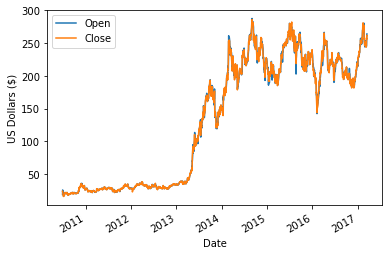

In [5]:
df[["Open", "Close"]].plot()
plt.ylabel("US Dollars ($)");

#### Calculating the volatility of the dataset:

$ Volatility = Daily Return Standard Deviation * \sqrt(Yearly Trading Days) $

In [6]:
daily_returns = np.zeros(250)
for i in range(len(df)-250,len(df)):
    daily_returns[i-1-len(df)+250] = np.log(df["Close"][i]/df["Close"][i-1])

daily_returns

array([-5.10596556e-02,  2.29619396e-02,  1.09605474e-02, -5.64695165e-04,
       -1.41790742e-02,  1.26135119e-02,  3.34676562e-02,  3.88013880e-02,
        3.37571196e-02,  3.82085362e-02, -3.14594870e-02, -2.81131324e-02,
       -6.00048013e-04, -8.43815421e-03,  2.67159989e-02, -1.05453218e-02,
        1.04667268e-02, -2.47837417e-03, -2.59765629e-02,  1.04557434e-02,
       -6.74352501e-03,  2.17521407e-02, -7.63495598e-03,  7.59556605e-03,
       -8.98643831e-03, -1.50649668e-02, -2.84581694e-02,  4.31038468e-03,
       -3.99951888e-02, -4.29190426e-02, -5.08298915e-02,  1.59455335e-02,
       -2.83609672e-02, -1.10148714e-03,  1.29297274e-03, -8.07234816e-03,
        1.59079308e-03,  3.26998132e-03, -1.75812206e-02,  3.13134016e-02,
        1.89508413e-02,  2.32851317e-02, -1.86030474e-02,  7.78573938e-03,
        7.63448805e-03,  2.49169312e-02, -9.28247497e-03,  8.51515971e-04,
       -1.65770776e-02, -2.73643787e-03,  1.36992804e-04,  7.68756718e-03,
        5.14881422e-02,  

In [7]:
annual_volatility = np.std(daily_returns) * 250**0.5
annual_volatility

### Model Numerical Solution Class:

#### Equation and Boundary Conditions:

In log-variables the BS PDE is:

$$ \frac{\partial  V(t,x)}{\partial t}  
          + \biggl( r -\frac{1}{2}\sigma^2 \biggr) \frac{\partial V(t,x)}{\partial x}
          + \frac{1}{2} \sigma^2 \frac{\partial^2  V(t,x)}{\partial x^2} - r  V(t,x)  = 0. $$

For an option with strike $K$ and maturity $T$, the boundary conditions are:

CALL:
 - Terminal:
 $$ V(T,x) = \max(e^x-K,0), $$
 - Lateral:
 $$ V(t, x) \underset{x \to -\infty}{=} 0  ,  \quad V(t, x) \underset{x \to \infty}{\sim} e^x - Ke^{-r(T-t)}. $$

PUT:
 - Terminal:
 $$ V(T,x) = \max(K-e^x,0), $$
 - Lateral:
  $$ V(t, x) \underset{x \to -\infty}{\sim} Ke^{-r(T-t)} , \quad V(t, x) \underset{x \to \infty}{=} 0. $$

#### Finite Difference and Partial Derivatives Approximation:

\begin{equation}
 \frac{\partial V(t,x)}{\partial x} \approx \frac{V(t,x+\Delta x) - V(t,x-\Delta x)}{2 \Delta x} + \mathcal{O}(\Delta x^2)
\end{equation}

\begin{equation}
 \frac{\partial V(t,x)}{\partial t} \approx \frac{V(t+\Delta t,x) - V(t-\Delta t,x)}{2 \Delta t} + \mathcal{O}(\Delta t^2)
\end{equation}

\begin{equation}
 \frac{\partial^2 V(t,x)}{\partial x^2} \approx \frac{V(t,x+\Delta x) + V(t,x-\Delta x) - 2V(t,x)}{ \Delta x^2} + \mathcal{O}(\Delta x^2)
\end{equation}


<a id='sec1.2'></a>
## Implicit discretization


First we have to restrict the theoretical infinite domain to the finite region $[t_0,T]\, \times \, [A_1,A_2]$, with $A_1 < A_2$. 

The next step is to replace $[t_0,T]\times [A_1,A_2]$ by a discrete grid:

For $n = 0,1, ... N \in \mathbb{N}$, define the discrete time step $ \Delta t = \frac{T - t_0}{N} $ such that
$t_n = t_0 + n \Delta t$. For $i = 0,1, ... M \in \mathbb{N}$, define the discrete space step $ \Delta x = \frac{A_2 - A_1}{M} $ such that
$x_i = A_1 + i \Delta x$.

The grid is divided into equally spaced nodes of distance $\Delta x$ in the x-axis, and of distance $\Delta t$ in the t-axis.

The mesh points have the form $(t_0 + n \Delta t, A_1 + i \Delta x)$.
At this point we concern ourselves only with the values of $V(t,x)$ on the mesh nodes. We call 

$$ V(t_0 + n \Delta t, A_1 + i \Delta x) = V_{n,i} .$$


The Equation in discreet form becomes:

$$ \begin{aligned}
\frac{V_{n+1, i} -V_{n, i}}{\Delta t} + 
(r-\frac{1}{2}\sigma^2) \frac{V_{n, i+1} -V_{n, i-1}}{ 2 \Delta x}
+ \frac{1}{2} \sigma^2 \frac{V_{n, i+1} + V_{n, i-1} - 2 V_{n,i}}{\Delta x^2}  - r V_{n, i} = 0.
\end{aligned}$$

Rearranging the terms: 

$$ \begin{aligned}
 V^{n+1}_{i} &= V^{n}_{i} \biggl( 1 + r\Delta t + \sigma^2 \frac{\Delta t}{\Delta x^2} \biggr)  \\
& + V^{n}_{i+1} \biggl( -(r -\frac{1}{2}\sigma^2)\frac{\Delta t}{2 \Delta x} -
\frac{1}{2}\sigma^2 \frac{\Delta t}{\Delta x^2}  \biggr)  \\
& + V^{n}_{i-1} \biggl( (r -\frac{1}{2}\sigma^2)\frac{\Delta t}{2 \Delta x} - 
\frac{1}{2}\sigma^2 \frac{\Delta t}{\Delta x^2}  \biggr).
\end{aligned} $$

We can rename the coefficients such that:   

$$ V_{n+1, i} = a V_{n, i-1} + b V_{n, i} + c V_{n, i+1}, $$

and write it in matrix form:

$$
\left(
\begin{array}{c}
V_{n+1, 1} \\
V_{n+1, 2} \\
\vdots \\
V_{n+1, M-2} \\
V_{n+1, M-1} \\
\end{array}
\right) = 
\underbrace{
\left(
\begin{array}{ccccc}
b     & c  & 0 & \cdots  & 0 \\
a     & b  & c & 0  & 0  \\
0      & \ddots & \ddots &   \ddots     & 0  \\
\vdots & 0 & a & b  & c  \\
0      & 0 & 0 & a  & b \\
\end{array}
\right) }_{\mathcal{D}} \cdot
\left(
\begin{array}{c}
V_{n, 1} \\
V_{n, 2} \\
\vdots \\
V_{n,M-2} \\
V_{n_M-1} 
\end{array}
\right)
+ \underbrace{
\left(
\begin{array}{c}
 a V_{n, 0} \\
  0 \\
 \vdots \\
 0 \\
c V_{n, M} \\
\end{array}
\right) }_{B (boundary terms)}
$$

The system 

$$ V^{n+1} = \mathcal{D} V^{n} + B $$

#### Implementation:

In [12]:
class BSM:
    def __init__(self, r, sigma,K, S_0,period, space_steps=3000, time_steps=2000, initial_time=0) -> None:
        self.__r = r
        self.__sigma = sigma
        self.__K = K
        self.__period = period
        self.__S_0 = S_0
        self.__x_0 = np.log(self.__S_0)
        self.__time_steps = time_steps
        self.__space_steps = space_steps
        self.__S_max = 3*self.__K 
        self.__S_min = self.__K/3 
        self.__x_max = np.log(self.__S_max)
        self.__x_min = np.log(self.__S_min)
        self.__X, self.__dx = np.linspace(self.__x_min, self.__x_max, self.__space_steps, retstep=True)
        self.__T, self.__dt = np.linspace(initial_time, self.__period, self.__time_steps, retstep=True)

    def __calc_coeff(self)->tuple[float, float, float]:
        sig2 = self.__sigma*self.__sigma; dxx = self.__dx * self.__dx

        a = ( (self.__dt/2) * ( (self.__r-0.5*sig2)/self.__dx - sig2/dxx ) )
        b = ( 1 + self.__dt * ( sig2/dxx + self.__r ) )
        c = (-(self.__dt/2) * ( (self.__r-0.5*sig2)/self.__dx + sig2/dxx ) )

        return a, b, c

    def __coeff_matrix(self):
        a, b, c = self.__calc_coeff()

        D = sparse.diags([a, b, c], [-1, 0, 1], shape=(self.__space_steps-2, self.__space_steps-2)).tocsc()
        return D


    def __solve(self, terminal_condition, boundary_condition_1, boundary_condition_2):
        V = np.zeros((self.__space_steps, self.__time_steps))
        #terminal condition
        Payoff = terminal_condition
        V[:, -1] = Payoff
        #boundary conditions
        V[0, :] = boundary_condition_1
        V[-1, :] = boundary_condition_2
        offset = np.zeros(self.__space_steps-2)
        a, b, c = self.__calc_coeff()
        D = self.__coeff_matrix()
        
        for i in range(self.__time_steps-2,-1,-1):
            offset[0] = a * V[0,i]
            offset[-1] = c * V[-1,i]; 
            V[1:-1,i] = spsolve( D, (V[1:-1,i+1] - offset) ) 
        
        return V

    def solve_call(self):
        #terminal condition
        terminal_condition = np.maximum(np.exp(self.__X)-self.__K, 0)
        #boundary conditions
        boundary_condition_1 = 0
        boundary_condition_2 = np.exp(self.__x_max) - self.__K * np.exp(-self.__r* self.__T[::-1] )
       
        return self.__solve(terminal_condition, boundary_condition_1, boundary_condition_2)

    def solve_put(self):
        #terminal condition
        terminal_condition = np.maximum(self.__K-np.exp(self.__X), 0)
        #boundary conditions
        boundary_condition_2 = 0
        boundary_condition_1 = self.__K * np.exp(-self.__r* self.__T[::-1] )
        
        return self.__solve(terminal_condition, boundary_condition_1, boundary_condition_2)
    
    def solve_call_for(self, S0, t):
        return np.interp(np.log(S0), self.__X, self.solve_call()[:, t])

    def solve_put_for(self, S0, t):                                                                     
        return np.interp(np.log(S0), self.__X, self.solve_put()[:, t])
    
    def calc_and_graph(self,type="Call"):
        X, Y = np.meshgrid(self.__T, np.exp(self.__X))
        V = []
        if type=="Call":
            V = self.solve_call()
        else:
            V = self.solve_put()

        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(Y, X, V, cmap=cm.CMRmap)
        ax.set_title(f"{type} option surface")
        ax.set_xlabel("S");
        ax.set_ylabel("t"); 
        ax.set_zlabel("Call Option Price")
        ax.view_init(30, -50)
        plt.show()



In [13]:
r = 0.1
sig = annual_volatility               
S0 = 100          
K = 400

expiration_period = 1      
test = BSM(r, sig, K, S0, expiration_period)

In [14]:
prices = [100,200,300,400,500]

for S in prices:
    print(test.solve_call_for(S,0),test.solve_put_for(S,0))

0.0 361.9349672143838
1.298426242685321 186.68015276387595
19.330262519734976 82.53561793963438
71.43806137264001 33.44568157160383
150.29075435554728 12.231402349837719


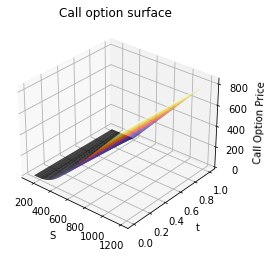

In [15]:
test.calc_and_graph()

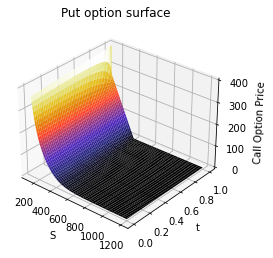

In [16]:
test.calc_and_graph("Put")